In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/drive')

traindata_path = '/content/drive/MyDrive/ddos/KDDTrain+.txt'
testdata_path = '/content/drive/MyDrive/ddos/KDDTest+.txt'

col_names = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
            ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
            ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
            ,'dst_host_srv_rerror_rate','attack','outcome']

# Read CSV files using Pandas
traindata = pd.read_csv(traindata_path, header=None, names = col_names)
testdata = pd.read_csv(testdata_path, header=None, names = col_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
for i in ['protocol_type',"service","flag"]:
    traindata[i] = traindata[i].astype('category').cat.codes
    testdata[i] = testdata[i].astype('category').cat.codes

In [ ]:
def lab(traindata):

    classlist = []

    check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
    check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
    check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
    check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")


    for item in traindata.pop('attack'):
        if item in check1:
            classlist.append("DoS")
        elif item in check2:
            classlist.append("Probe")
        elif item in check3:
            classlist.append("U2R")
        elif item in check4:
            classlist.append("R2L")
        else:
            classlist.append("ANormal")

    return classlist

y_train = np.array(lab(traindata))
y_test = np.array(lab(testdata))

In [ ]:
unique_values = np.unique(y_train)
print(unique_values)

['ANormal' 'DoS' 'Probe' 'R2L' 'U2R']


In [ ]:
def normalize(df, cols):
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
trainX = pd.DataFrame(normalize(traindata,traindata.columns))
trainT = pd.DataFrame(normalize(testdata,testdata.columns))

NameError: name 'pd' is not defined

In [ ]:

# Define the model and parameters
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Setup the grid search
grid = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='accuracy')
grid.fit(trainX, y_train)

# Output the best parameters and best score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.9986822602703438


In [ ]:

predictions = grid.predict(trainT)


In [ ]:
class_names = ['Normal','DoS','Probe','R2L','U2R']

In [ ]:

# Generate a classification report
report = classification_report(y_test, predictions, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Normal       0.74      0.98      0.84      9889
         DoS       0.92      0.85      0.89      7460
       Probe       0.79      0.69      0.73      2421
         R2L       0.95      0.12      0.21      2707
         U2R       0.36      0.45      0.40        67

    accuracy                           0.80     22544
   macro avg       0.75      0.62      0.61     22544
weighted avg       0.83      0.80      0.77     22544



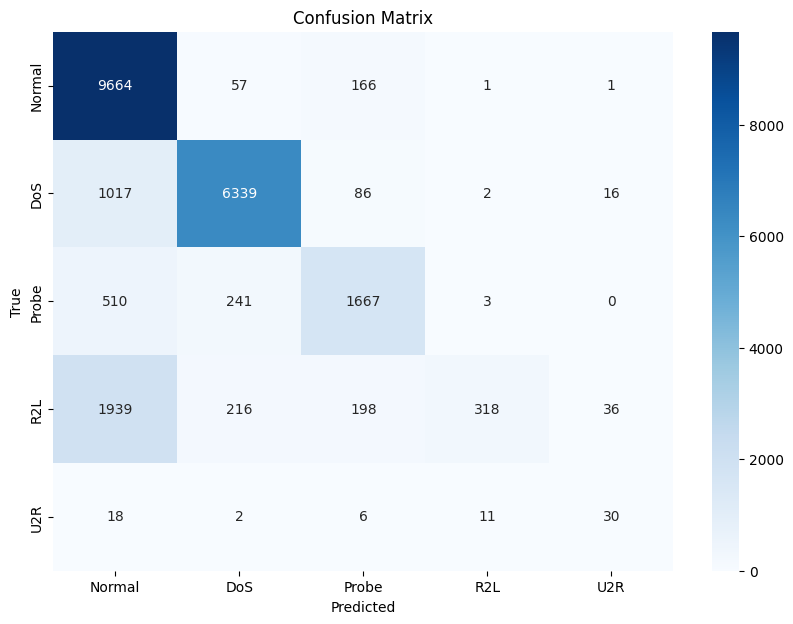

In [ ]:

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()